# Script to calculate future droughts over Ghana from P and T area means (multiple models)

- Author: Jess Baker (j.c.baker@leeds.ac.uk)
- adapted from Sarah's Chapman's notebook
- includes code from Eszter Kovac's drought notebook
- adapted 'make_cmip6_filepath' function to accomodate multiple model fpaths
- code to get the institute for each model

## Description
Code to read in CMIP6 model output from multiple models. Historical and future precipitation and temperature are read in, joined to form a continuous dataset from 1980 to 2100, subset over Ghana (all, north and south area means) and used to calculate interannual variation in the SPEI drought index. SPEI from each model is plotted as a time series.

Some useful links
https://towardsdatascience.com/basic-data-structures-of-xarray-80bab8094efa

In [1]:
import os
import numpy as np
import xarray as xr
import glob
import datetime
from datetime import datetime as dt
from pyhdf.SD import SD, SDC
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import cf_units
import pandas as pd
import copy
import climate_indices
from climate_indices import compute, indices
import iris
from netCDF4 import date2num
import iris.coord_categorisation
from iris.experimental.equalise_cubes import equalise_attributes
from iris.util import unify_time_units

import os 

def get_dates(cube, verbose=False):
    dates = cube.coord('time').units.num2date(cube.coord('time').points)
    dates = [dt(date.year, date.month, date.day) for date in dates]
    if verbose is True:
        print(dates)
    else:
        print(dates[0], '–', dates[-1])
    return(dates)


def merge_hist_future_cmip6(hist_cube, future_cube):
    # combine hist and future data into single cube
    hist_dates = get_dates(hist_cube)
    calendar = 'gregorian'
    units = 'days since ' + str(hist_dates[0].year) + '-01-01 00:00:0.0'
    
    future_dates = get_dates(future_cube)
    
    if future_dates[0].year <= hist_dates[-1].year:
        # if future and historical cubes overlap remove overlap
        print(hist_dates[0].year)
        print(future_dates[0].year)
        hist_constraint = iris.Constraint(time=lambda cell: hist_dates[0].year <= cell.point.year < future_dates[0].year)
        hist_cube = hist_cube.extract(hist_constraint)
        hist_dates = get_dates(hist_cube)
        
    dates = hist_dates + future_dates
    
    # get time dimension
    times = date2num(dates, units=units, calendar=calendar)
    time_unit = cf_units.Unit(units, calendar=calendar)
    time = iris.coords.DimCoord(times, standard_name='time',
                                units=time_unit)

    lats = future_cube.coord('latitude').points
    latitude = iris.coords.DimCoord(lats, standard_name='latitude',
                                    units='degrees')
    lons = future_cube.coord('lon').points
    longitude = iris.coords.DimCoord(lons, standard_name='longitude',
                                     units='degrees')
    new_data = np.zeros((len(dates), len(lats), len(lons)))
    
    # add historical data
    new_data[0:hist_cube.shape[0], :, :] = hist_cube.data
    new_data[hist_cube.shape[0]:, :, :] = future_cube.data
    
    # Put data into data cube
    cube = iris.cube.Cube(new_data, var_name=future_cube.standard_name,
                          units=future_cube.units,
                          dim_coords_and_dims=[(time, 0), (latitude, 1),
                                               (longitude, 2)])
    print(cube)
    return(cube)


def make_cmip6_filepath(institute, model, scenario, variant, experiment, table_id, variable, grid, version, time_range,
                        data_root="/badc/cmip6/data/CMIP6/"):
    """
    Make a file path for a cmip6 dataset for a single variable
    Historical runs (1850-2014) are in `/badc/cmip6/data/CMIP6/CMIP/<institute>/<model>/historical/<variant>/<table_id>/<variable>/<grid>/<version>/`
    Scenario runs are in `/badc/cmip6/data/CMIP6/ScenarioMIP/<institute>/<model>/<scenario_name>/<variant>/<table_id>/<variable>/<grid>/<version>/`
    `scenario_name` is likely to be one of ssp119, ssp126, ssp245, ssp370 or ssp585
    `variant` takes the form `r<realiation_id>0<initialization_id>0<physics_id>0<forcing_id>`, e.g. `r1i1p1f2`, where the numbers are the indexes for:  
    **r**ealization, **i**nitialization, **p**hysics, **f**orcing
    `table_id` generally indicates the frequency of the data, e.g. day, 3hr, Amon
    `grid` is the model grid being used, e.g. gn, where  
       * `gm`: global mean data  
       * `gn`: data reported on a model's native grid  
       * `gr1`: regridded data reported on a grid other than the native grid and other than the preferred target grid  
    It is likely the `grid` will be the native grid, i.e. `gn`
    `version` normally in the form `v[YYYYMMDD]` or `latest`, e.g. `v20200203
    
    `variable` generally follows the list on https://pcmdi.llnl.gov/mips/cmip3/variableList.html, for example 
       `tas`: air_temperature 
       `pr`: precipitation_flux
       `ts`: surface_temperature
    The following institutions have data in both historical and ScenarioMIPs:
    AS-RCEC, AWI, BCC, CAMS, CAS, CCCR-IITM, CCCma, CMCC, CNRM-CERFACS, CSIRO, CSIRO-ARCCSS, E3SM-Project, EC-Earth-Consortium, FIO-QLNM, HAMMOZ-Consortium, INM, IPSL, KIOST, MIROC, MOHC, MPI-M, MRI, NASA-GISS, NCAR, NCC, NIMS-KMA, NOAA-GFDL, NUIST, THU, UA
    """
    # get base path
    path = str(DATA_ROOT / scenario / institute / model / experiment)
    print(path)
    #print(os.listdir(path))
    
    # get path for variant
    if variant is None:
        # select first variant
        dir_list = os.listdir(path)
        variant_list = [x for x in dir_list if x.startswith('r')]
    else:
        variant_list = [variant]
    
    # update path
    var = [x for x in variant_list if x.startswith('r1i1p1')]
    if len(var) == 0:
        print(variant_list)
        var = [x for x in variant_list if x.startswith('r')]
        path = path + '/' + var[0] + '/' + str(table_id) + '/' + str(variable)
    else:
        path = path + '/' + var[0] + '/' + str(table_id) + '/' + str(variable) 
    print(path)
    # get path for grid
    if grid is None:
        # select first grid (usually only 1)
        dir_list = os.listdir(path)
        grid_list = [x for x in dir_list if x.startswith('g')]
    else:
        grid_list = [grid]
        
    # update path
    path = path + '/' + str(grid_list[0])
    print(path)
    
    # get version path
    if version is None:
        dir_list2 = os.listdir(path)
        version_list = [x for x in dir_list2 if x.startswith('v')]
    else:
        version_list = [version]
    
    # update path
    path = path + '/' + str(version_list[0]) + '/'
    print(path)
    print(os.listdir(path))
    return(path+ '*.nc')

# test
DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")
model = "UKESM1-0-LL"
expt = 'ssp585'
scenario = 'ScenarioMIP'
fp = make_cmip6_filepath(
        institute="MOHC", scenario=scenario, model=model, experiment=expt, variant=None,
        table_id="Amon", variable="pr", grid=None, version=None, time_range="*"
    )

/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Amon/pr
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Amon/pr/gn
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Amon/pr/gn/v20190507/
['pr_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_201501-204912.nc', 'pr_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc']


In [2]:
# create dictionary of models and institutes
basepath = '/badc/cmip6/data/CMIP6/CMIP/'
institute_list = os.listdir(basepath)
model_inst_dict = {}

# loop over institutes
for inst in institute_list:
    model_list = os.listdir(basepath + inst + '/')
    
    # for each institute list models and store in dictionary
    for model_temp in model_list:
        model_inst_dict[model_temp] = inst
    
    # correction for UKESM which is used by multiple centres - we want MOHC only
    model_inst_dict['UKESM1-0-LL'] = 'MOHC'
    
print(model_inst_dict)

{'TaiESM1': 'AS-RCEC', 'UKESM1-0-LL': 'MOHC', 'AWI-CM-1-1-MR': 'AWI', 'AWI-ESM-1-1-LR': 'AWI', 'BCC-CSM2-MR': 'BCC', 'BCC-ESM1': 'BCC', 'CAMS-CSM1-0': 'CAMS', 'CAS-ESM2-0': 'CAS', 'FGOALS-f3-L': 'CAS', 'FGOALS-g3': 'CAS', 'IITM-ESM': 'CCCR-IITM', 'CanESM5': 'CCCma', 'CanESM5-CanOE': 'CCCma', 'CMCC-CM2-HR4': 'CMCC', 'CMCC-CM2-SR5': 'CMCC', 'CMCC-ESM2': 'CMCC', 'CNRM-CM6-1': 'CNRM-CERFACS', 'CNRM-CM6-1-HR': 'CNRM-CERFACS', 'CNRM-ESM2-1': 'CNRM-CERFACS', 'ACCESS-ESM1-5': 'CSIRO', 'ACCESS-CM2': 'CSIRO-ARCCSS', 'E3SM-1-0': 'E3SM-Project', 'E3SM-1-1': 'E3SM-Project', 'E3SM-1-1-ECA': 'E3SM-Project', 'EC-Earth3': 'EC-Earth-Consortium', 'EC-Earth3-AerChem': 'EC-Earth-Consortium', 'EC-Earth3-CC': 'EC-Earth-Consortium', 'EC-Earth3-LR': 'EC-Earth-Consortium', 'EC-Earth3-Veg': 'EC-Earth-Consortium', 'EC-Earth3-Veg-LR': 'EC-Earth-Consortium', 'EC-Earth3P-VHR': 'EC-Earth-Consortium', 'FIO-ESM-2-0': 'FIO-QLNM', 'MPI-ESM-1-2-HAM': 'HAMMOZ-Consortium', 'INM-CM4-8': 'INM', 'INM-CM5-0': 'INM', 'IPSL-CM5A2

### Run the next cell if you wish to perform the calculation. If already calculated and saved output then you can jump to the next cell

In [6]:
assert False  

# Read in temperature and precipitation over Ghana

# useful guide here: https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_02_Xarray_subset_slicing_plot_CMIP6.html
DATA_ROOT = Path("/badc/cmip6/data/CMIP6/")
pr_datasets = {}
tas_datasets = {}

scenario = 'ScenarioMIP'

# read in monthly data
models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CanESM5',
          'CNRM-CM6-1', 'CNRM-ESM2-1', 'FGOALS-f3-L', 'FGOALS-g3', 'HadGEM3-GC31-MM',
          'GISS-E2-1-G', 'INM-CM5-0', 'INM-CM4-8',
          'MPI-ESM1-2-LR', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL'] 

# models without SSP585 pr OR tas or have issues with data ('MRI-ESM2-0', )
# 'BCC-ESM1', 'CESM2', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'NorCPM1', 'MRI-ESM2-0', 

# Loop over multiple experiments and calculate SPEI for all, north and south Ghana
for expt in ['ssp119', 'ssp126', 'ssp245', 'ssp585']:

    for model in models:
        print(model)
        institute = model_inst_dict[model]

        if model in ['UKESM1-0-LL']:  #something wrong with UKESM r1i1p1 variant (hdf error)
            variant = 'r2i1p1f2'
        else:
            variant = None

        if expt == 'ssp245':
            if model == 'HadGEM3-GC31-MM':  # this model doesn't provide ssp245 output
                continue
            if model == 'GISS-E2-1-G':  # this model has missing data
                continue
        try:
            # get historical precip data
            fp_hist = make_cmip6_filepath(
                institute=institute, scenario='CMIP', model=model, experiment='historical', variant=variant,
                table_id="Amon", variable="pr", grid=None, version=None, time_range="*"
            )
            hist_pr_cube = xr.open_mfdataset(fp_hist)
            hist_pr_cube = hist_pr_cube.assign_coords(lon=(((hist_pr_cube.lon + 180) % 360) - 180)).sortby('lon') # change lons from 0,360 to -180,180

            # select data over Ghana and convert to Iris cube
            hist_ghana_pr = hist_pr_cube.sel(lat=slice(4.5,11.5), lon=slice(-3.5,1))
            hist_ghana_pr = hist_ghana_pr.pr.to_iris()

            fp_future = make_cmip6_filepath(
                institute=institute, scenario=scenario, model=model, experiment=expt, variant=variant,
                table_id="Amon", variable="pr", grid=None, version=None, time_range="*"
            )

            future_pr_cube = xr.open_mfdataset(fp_future)
            future_pr_cube = future_pr_cube.assign_coords(lon=(((future_pr_cube.lon + 180) % 360) - 180)).sortby('lon') # change lons from 0,360 to -180,180

            # select data over Ghana and convert to Iris cube
            future_ghana_pr = future_pr_cube.sel(lat=slice(4.5,11.5), lon=slice(-3.5,1))
            future_ghana_pr = future_ghana_pr.pr.to_iris()

            # combine hist and future precip data into single cube
            cube = merge_hist_future_cmip6(hist_ghana_pr, future_ghana_pr)

            pr_datasets[model] = cube

            # repeat for tas
            fp_hist = make_cmip6_filepath(
                institute=institute, scenario='CMIP', model=model, experiment='historical', variant=variant,
                table_id="Amon", variable="tas", grid=None, version=None, time_range="*"
            )
            hist_tas_cube = xr.open_mfdataset(fp_hist)

            # change longitudes from 0,360 to -180,180
            hist_tas_cube = hist_tas_cube.assign_coords(lon=(((hist_tas_cube.lon + 180) % 360) - 180)).sortby('lon')

            # select data over Ghana
            hist_ghana_tas = hist_tas_cube.sel(lat=slice(4.5,11.5), lon=slice(-3.5,1))
            hist_ghana_tas = hist_ghana_tas.tas.to_iris()

            fp_future = make_cmip6_filepath(
                institute=institute, scenario=scenario, model=model, experiment=expt, variant=variant,
                table_id="Amon", variable="tas", grid=None, version=None, time_range="*"
            )

            future_tas_cube = xr.open_mfdataset(fp_future)

            # change longitudes from 0,360 to -180,180
            future_tas_cube = future_tas_cube.assign_coords(lon=(((future_tas_cube.lon + 180) % 360) - 180)).sortby('lon')

            # select data over Ghana
            future_ghana_tas = future_tas_cube.sel(lat=slice(4.5,11.5), lon=slice(-3.5,1))
            future_ghana_tas = future_ghana_tas.tas.to_iris()

            # combine hist and future data into single cube
            cube = merge_hist_future_cmip6(hist_ghana_tas, future_ghana_tas)

            tas_datasets[model] = cube
            
        except FileNotFoundError:
            print(model, ' has no SSP119 output')
        
    outpath = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
    np.save(outpath + 'hist_plus_' + expt + '_ghana_pr_dict.npy', pr_datasets)
    np.save(outpath + 'hist_plus_' + expt + '_ghana_tas_dict.npy', tas_datasets) 

AssertionError: 

In [7]:
# load dictionaries saved in previous cell
#expt = 'ssp245' #'ssp585'
expt = 'ssp119'
path = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
pr_datasets = np.load(path + 'hist_plus_' + expt + '_ghana_pr_dict.npy').item()
tas_datasets = np.load(path + 'hist_plus_' + expt + '_ghana_tas_dict.npy').item()
print(pr_datasets.keys())

dict_keys(['CAMS-CSM1-0', 'CanESM5', 'CNRM-ESM2-1', 'FGOALS-g3', 'GISS-E2-1-G', 'UKESM1-0-LL'])


### Run the next cell if you wish to perform the calculation. If already calculated and saved output then you can jump to the next cell

In [8]:
assert False

# Calculate the SPEI drought index

# load dictionaries we've just saved

# convert to iris cube and extract lat and lon arrays
time_constraint = iris.Constraint(time=lambda cell: 1980 <= cell.point.year <= 2100)
constraint_lon = iris.Constraint(longitude = lambda cell: 6 <= cell.point < 8)
constraint_lat = iris.Constraint(latitude = lambda cell: -3 <= cell.point < 1)
constraint = time_constraint  & constraint_lon & constraint_lat 

# convert to iris cube and extract lat and lon arrays
pr_temp = pr_datasets["UKESM1-0-LL"].extract(time_constraint)
print(pr_temp)

lon = pr_temp.coord('longitude').points
lat = pr_temp.coord('latitude').points

dates = get_dates(pr_temp)
startyear = dates[0].year
calib_year_init = startyear
calib_year_final = 2010

spei_dict = {}
spei_north_dict = {}
spei_south_dict = {}
pet_dict = {}

for key in [x for x in pr_datasets.keys()][:]:
    print(key)
    if key in ['MRI-ESM2-0']:
        print(key, ' SKIPPED!')
        # issue with time coordinate
        continue

    print(key)
    
    pr_temp = pr_datasets[key].extract(time_constraint).collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
    print(pr_temp)
    
    tas_temp = tas_datasets[key].extract(time_constraint).collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
    dims = pr_temp.shape

    #create cubes for storing data
    spei_cube = copy.deepcopy(pr_temp)  #np.array((pr_temp.shape))
    pet_cube = copy.deepcopy(pr_temp)   #np.array((pr_temp.shape))

    pr_ds = pr_datasets[key]
    pr_ds = pr_ds.extract(time_constraint).collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
    pr_ds.convert_units('kg m-2 day-1')
    
    tas_ds = tas_datasets[key]
    tas_ds = tas_ds.extract(time_constraint).collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
    tas_ds.convert_units('Celsius')
    
    try:

        x_pr = pr_ds[:].data
        x_tas = tas_ds[:].data

        temp_lat = pr_ds[0].coord('latitude').points[0]

        #calculate pet
        pet = indices.pet(x_tas, temp_lat, startyear)
        pet_cube.data[:] = pet

        #calculate spei
        kwargs = dict(
            precips_mm = x_pr,
            pet_mm = pet[0:dims[0]],
            scale = 1, # months over which to calculate SPEI, i.e., 3 month running mean etc
            distribution = indices.Distribution.gamma,
            periodicity = indices.compute.Periodicity.monthly, #time scale of input data (needs to be monthly for SPEI)
            data_start_year = startyear,
            calibration_year_initial = calib_year_init,
            calibration_year_final = calib_year_final,
            fitting_params=None
        )
        spei = indices.spei(**kwargs)

        spei_cube.data[:] = spei
            
        spei_dict[key] = spei_cube
        
        #save north and south
        spei_north = spei_cube.extract(iris.Constraint(latitude = lambda cell: cell >= 8.0))
        spei_south = spei_cube.extract(iris.Constraint(latitude = lambda cell: cell <= 8.0))

        spei_north_dict[key] = spei_north
        spei_south_dict[key] = spei_south

    except IndexError:
        print(key, 'ERROR WITH INDEXES - check shape of tas_ds and x_pr')
        print('pr_ds shape', pr_ds.shape)
        print('tas_ds shape', tas_ds.shape)
        continue

outpath = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
np.save(outpath+ 'hist_'+expt+'_all_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_area_mean.npy', spei_dict)
np.save(outpath+ 'hist_'+expt+'_n_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_area_mean.npy', spei_north_dict)
np.save(outpath+ 'hist_'+expt+'_s_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_area_mean.npy', spei_south_dict)

AssertionError: 

In [12]:
# load dicts saved in previous cell
path = '/home/users/jcabaker/agri_hackthon_cmip6/save_files/'
calib_year_init = 1980
calib_year_final = 2010

# select expt to read in
expt = 'ssp585'
spei_dict = np.load(path+ 'hist_'+expt+'_all_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_area_mean.npy').item()
spei_north_dict = np.load(path+ 'hist_'+expt+'_n_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_area_mean.npy').item()
spei_south_dict = np.load(path+ 'hist_'+expt+'_s_ghana_spei_dict_' + str(calib_year_init) + '-' + str(calib_year_final) + '_calib_area_mean.npy').item()

In [13]:
def cube_to_frame(cube_dict, expt='hist'): # set up in case calculate SPEI for multiple models
    df = pd.DataFrame(columns = ['model', 'expt', 'year', 'month', 'value'])
    
    for key in cube_dict.keys():
        cube_time_mean = cube_dict[key].copy()
        
        model = key #extract from attributes later
        
        x = cube_time_mean.data
        x = x[~x.mask].flatten() #if masked to land sea, which isn't as moment
        
        iris.coord_categorisation.add_year(cube_time_mean, 'time', name='year')
        iris.coord_categorisation.add_month(cube_time_mean, 'time', name='month')
        
        year =  cube_time_mean.coord('year').points
        #print(year)
        month = cube_time_mean.coord('month').points
        
        y = pd.DataFrame(columns =   ['model', 'expt', 'year', 'month', 'value'])
       
        y['value'] = x
        y['year'] = year
        y['model'] = model
        y['expt'] = expt
        y['month'] = month
        
        df= df.append(y)
    
    return(df)

#turn into dataframe and extract year
spei_df = cube_to_frame(spei_dict, expt=expt)
print(spei_df.head(3))
spei_north_df = cube_to_frame(spei_north_dict, expt=expt)
print(spei_north_df.head(3))
spei_south_df = cube_to_frame(spei_south_dict, expt=expt)
print(spei_south_df.head(3))

        model    expt  year month     value
0  ACCESS-CM2  ssp585  1980   Jan -0.875245
1  ACCESS-CM2  ssp585  1980   Feb  0.233239
2  ACCESS-CM2  ssp585  1980   Mar  0.718164
        model    expt  year month     value
0  ACCESS-CM2  ssp585  1980   Jan -0.875245
1  ACCESS-CM2  ssp585  1980   Feb  0.233239
2  ACCESS-CM2  ssp585  1980   Mar  0.718164
        model    expt  year month     value
0  ACCESS-CM2  ssp585  1980   Jan -0.875245
1  ACCESS-CM2  ssp585  1980   Feb  0.233239
2  ACCESS-CM2  ssp585  1980   Mar  0.718164


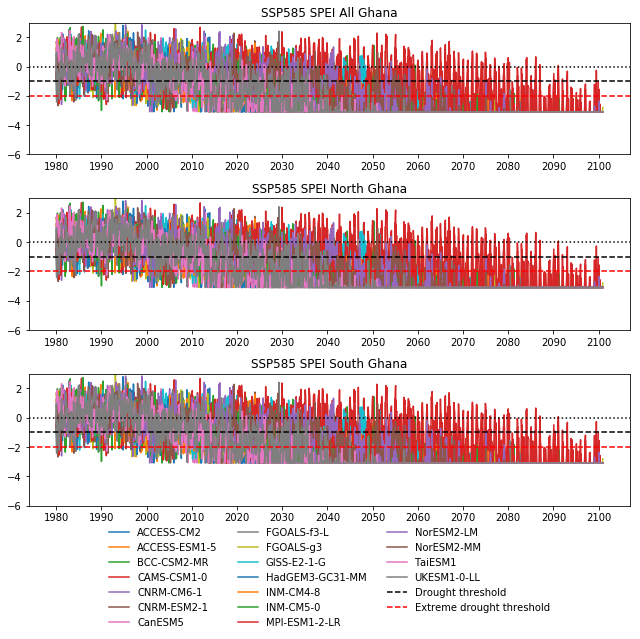

In [14]:
##plot time series
fig = plt.figure(figsize = (9,9))
ax =  fig.add_subplot(311)
ax2 =  fig.add_subplot(311)
ax3 =  fig.add_subplot(311)

titles = [' All Ghana', ' North Ghana', ' South Ghana']

subplot = 1
for df in [spei_df, spei_north_df, spei_south_df]:
    ax = fig.add_subplot(3, 1, subplot)
    for model in np.unique(spei_df['model'])[0:]:
        #print(model)
        #fig = plt.figure(figsize = (9,6))
        #ax =  fig.add_subplot(111)
        #continue
        years =  np.unique(spei_df['year'])
        #print(years)
        #print(len(spei_df[spei_df.model==model]))
        #assert False
        ax.plot(spei_df['value'][spei_df.model==model], label=model)#, c = 'black', label=model)
        #ax.set_title(model)
    
    ax.set_xticks(np.arange(0, len(spei_df[spei_df.model==model]), 120))
    ax.set_xticklabels(years[::10])
    ax.axhline(y = 0, color = 'black', linestyle = 'dotted')
    ax.axhline(y = -1, color = 'black', linestyle = 'dashed', label = 'Drought threshold')
    ax.axhline(y = -2, color = 'red', linestyle = 'dashed', label = 'Extreme drought threshold')
    ax.set_title(expt.upper() + ' SPEI' + titles[subplot-1]) 
    ax.set_ylim(-6, 3)
    
    subplot += 1
    
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.10), ncol = 3, frameon = False)
       
plt.tight_layout()
outpath = '/home/users/jcabaker/agri_hackthon_cmip6/' + expt + '_spei_multi_model_area_mean.png'
plt.savefig(outpath, dpi=300, bbox_inches='tight')